In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.set_printoptions(precision=3, suppress=True) # Make NumPy printouts easier to read

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset = dataset.dropna() # drop rows with unknown values
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'}) # 1 hot encode Origin column as it's categorical
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')

# split to train and test set
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

normalizer = tf.keras.layers.Normalization(axis=-1) # create normalization layer
normalizer.adapt(np.array(train_features)) # fit state of preprocessing layer to the data

first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


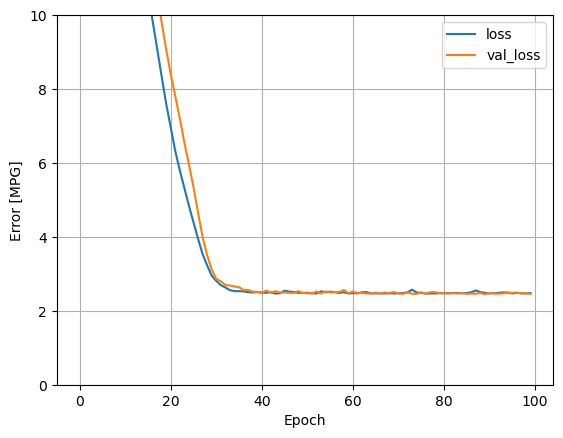

In [15]:
# linear regression with multiple inputs
# the model uses y=mx+b but m and b is a vector

linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

# compile model
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

# train
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0, # Suppress logging
    validation_split = 0.2) # validation results on 20% of the training data

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)
test_results = {}
test_results['linear_model'] = linear_model.evaluate(test_features, test_labels, verbose=0)

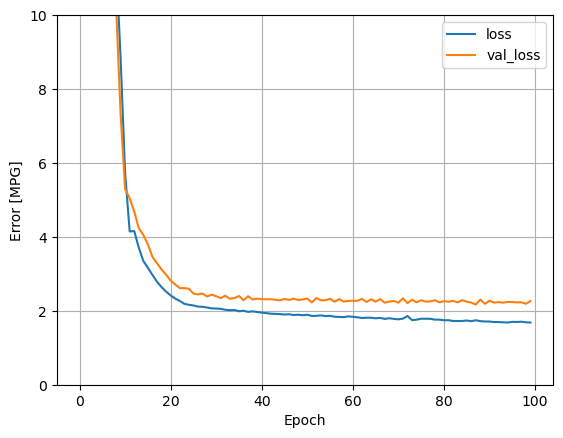

In [16]:
# regression with DNN
# the model is expanded to include hidden non-linear layers
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_model = build_and_compile_model(normalizer)


history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [17]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.490471
dnn_model,1.774630


3/3 [==============================] - 0s 1ms/step


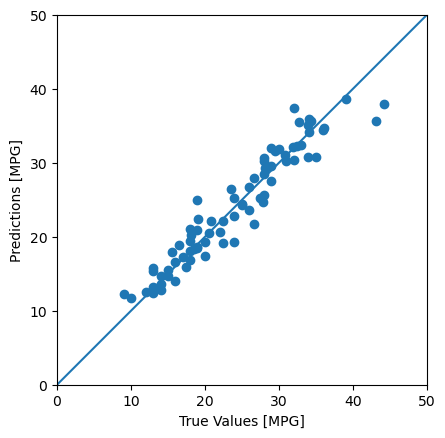

In [18]:
# evaluate using test set
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)



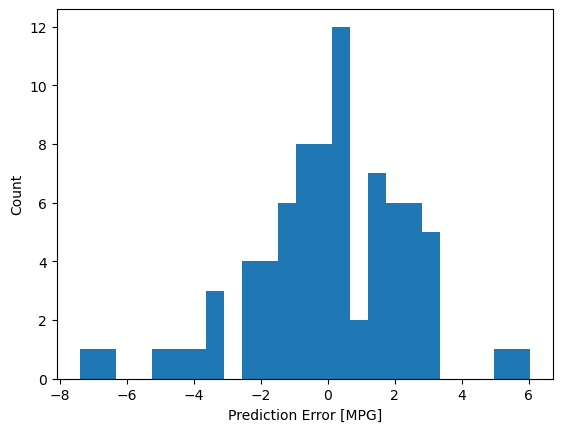

In [19]:
# error distribution
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [ ]:
dnn_model.save('dnn_model') 